In [ ]:
#import packages
import datetime as dat
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab
import scipy.stats as stats
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import time
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

In [ ]:

#load data
df = pd.read_csv('Data/dataframe.csv')

#drop the unamed column
df = df.drop(['Unnamed: 0'], axis=1)
#view data
df.head()

In [3]:
#deal with class imblanance

#first divide into target and features
# Specify the name of the target
target = 'EV'

# Get the target vector
y= df[target]

features = df.drop('dataid', axis=1)
# Specify the name of the features
features = list(features.drop(target,axis=1).columns)


# Get the feature vector
x= df[features]



from sklearn.model_selection import train_test_split

# Randomly choose 30% of the data for testing (using random_state = 0)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0, stratify=y)

from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)


In [4]:
#choose the best n_neighbors for KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
#try to plot KNN
#creating list of K for KNN
k_list = list(range(1,50,2))
# create a new list called cv_scores
cv_scores = []

# perform 10-fold cross validation
for k in k_list:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_resampled, y_resampled, cv=10, scoring='f1')
    cv_scores.append(scores.mean())
# find MSE
MSE = [1 - x for x in cv_scores]
#make a plot
plt.figure()
plt.figure(figsize=(15,10))
plt.title('Identifying the number of neighbors', fontsize=20, fontweight='bold')
plt.xlabel('Number of Neighbors', fontsize=15)
plt.ylabel('MSE', fontsize=15)
sns.set_style("whitegrid")
plt.plot(k_list, MSE)

plt.show()

#This pattern shows that less numbers may reduce MSE

In [5]:
# Delcare the model
rf = RandomForestClassifier(criterion='entropy',
            min_samples_leaf=2, min_samples_split=8,
                            n_estimators=40, n_jobs=1)

# Train the model
# use the fit method
result = rf.fit(X_resampled, y_resampled)


# Print the accuracy
print('Accuracy on train: ' + str(rf.score(X_resampled, y_resampled)), 'Accuracy on test: ' + str(rf.score(X_test, y_test)))

Accuracy on train: 0.8620689655172413 Accuracy on test: 0.6290322580645161


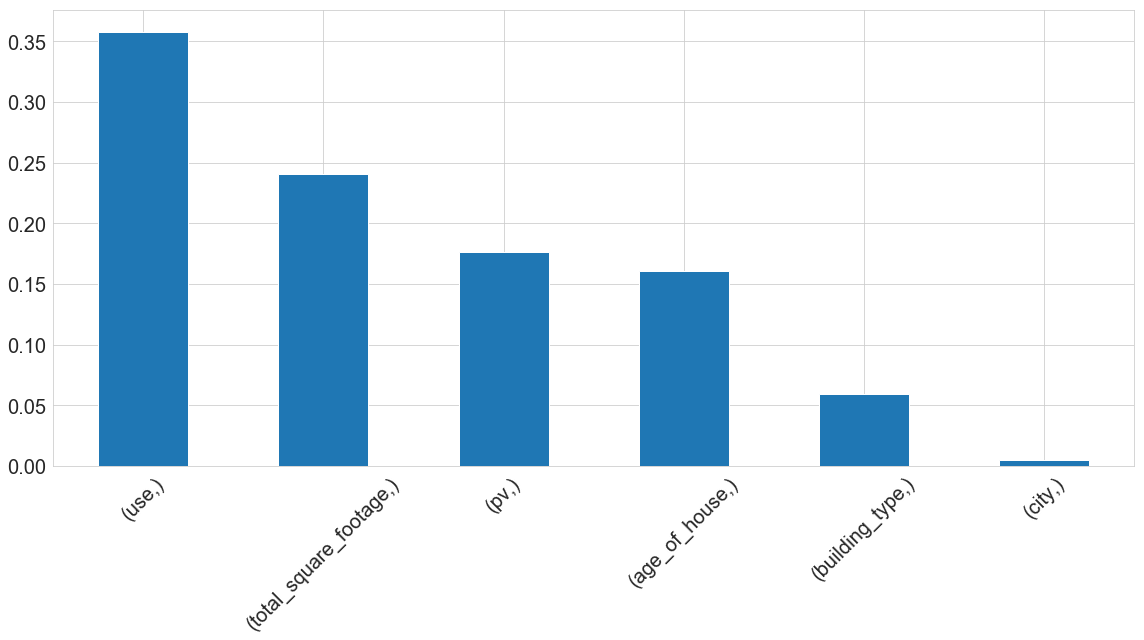

In [6]:
traindataframe = pd.DataFrame(X_resampled, columns=[features])

import matplotlib.pyplot as plt

# Convert the importances into one-dimensional 1darray with corresponding df column names as axis labels
# Implement me
f_importances = pd.Series(rf.feature_importances_, traindataframe.columns)

# Sort the array in descending order of the importances
# Implement me
f_importances = f_importances.sort_values(ascending=False)

# Draw the bar Plot from f_importances 
f_importances.plot(x='Features', y='Importance', kind='bar', figsize=(16,9), rot=45, fontsize=20)

# Show the plot
plt.tight_layout()
plt.show()

In [7]:
# models to try

#Logistic Regression
#K Nearest Neighbor
#Perceptron
#Decision Tree
#Support Vector Machine
#Random Forest

#import machine learning packages
from sklearn.linear_model import LogisticRegression
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
#from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
#from sklearn.ensemble import RandomForestClassifier


In [8]:
#create clfs
clfs = {'lr': LogisticRegression(random_state=0),
        'knn':KNeighborsClassifier(),
        'mlp': MLPClassifier(random_state=0)}
        'rf': RandomForestClassifier(random_state=0),
        'svc': SVC(random_state=0)}

In [9]:
#create pipline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

thresholds = [0, .05, .2]

pipe_clfs = {}

for name, clf in clfs.items():
    pipe_clfs[name] = {}
    for threshold in thresholds:
        pipe_clfs[name][threshold] = Pipeline([('StandardScaler', StandardScaler()), 
                                               ('SelectFromModel', SelectFromModel(estimator=RandomForestClassifier(random_state=0), 
                                                                                   threshold=threshold)), 
                                               ('clf', clf)])

In [10]:
#create paramter grids
param_grids = {}

In [11]:
#Logistic Regression
param_grid = [{'clf__multi_class': ['ovr'], 
               'clf__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}]

param_grids['lr'] = param_grid

In [12]:

#KNN

#create parameter grid for KNN
param_grid = [{'clf__n_neighbors': [2,10,11,12, 15, 30, 40], 
               'clf__algorithm':['auto','brute','kd_tree','ball_tree']}]
param_grids['knn'] = param_grid

In [13]:

#perceptron
param_grid = [{'clf__hidden_layer_sizes': [50, 100, 150],
               'clf__activation': ['identity', 'logistic', 'tanh', 'relu']}]

param_grids['mlp'] = param_grid

In [14]:
#create parameter grid for SVC
param_grid = [{'clf__C': [0.1, 1, 10, 20, 50],
               'clf__gamma': [0.1, 1, 10, 20, 50],
               'clf__kernel': ['rbf', 'sigmoid']}]

param_grids['svc'] = param_grid

In [15]:
#create parameter grid for random forest
param_grid = [{'clf__n_estimators': [5, 10, 20, 30, 40],
              'clf__min_samples_split': [10, 15, 20, 30, 40, 50],
               'clf__min_samples_leaf': [ 3, 4, 5, 7, 10, 15, 20]}]

param_grids['rf'] = param_grid

In [16]:

# The start time
start = time.time()




# The list of [best_score_, best_params_, best_estimator_]
best_score_param_estimators = []
#scoring = ['accuracy', 'precision', 'recall', 'f1']


# For each classifier
for name in pipe_clfs.keys():
    for threshold in thresholds:
        # GridSearchCV
        gs = GridSearchCV(estimator=pipe_clfs[name][threshold],
                          scoring='f1',
                          param_grid=param_grids[name],
                          n_jobs=1,
                          cv=StratifiedKFold(n_splits=5,
                                             shuffle=False,
                                           random_state=0))
        # Fit the pipeline
        gs = gs.fit(X_resampled, y_resampled)

        # Update best_score_param_estimators
        best_score_param_estimators.append([gs.best_score_, gs.best_params_, gs.best_estimator_])
        
# The end time
end = time.time()

# Print the Run time
print('Run time: ' + str(end - start))

C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0

C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in ve

C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in ve

C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 an

C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in ve

C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in ve

C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in ve

C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0

C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged 

Run time: 25.173075914382935


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [17]:
# Sort best_score_param_estimators in descending order of the best_score_
best_score_param_estimators = sorted(best_score_param_estimators, key=lambda x : x[0], reverse=True)

# Print the best_estimator
print('best_estimator:', end=' ')
print(best_score_param_estimators[0][2].named_steps['clf'], end='\n\n')

# Print the threshold used by the best_estimator
print('threshold:', end=' ')
print(best_score_param_estimators[0][2].named_steps['SelectFromModel'].threshold_)

#print the score
print('score:', end='')
print(best_score_param_estimators[0][0])

print(len(best_score_param_estimators))

best_estimator: MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=100, learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=0, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

threshold: 0.0
score:0.6550977757874309
3


In [18]:
#confusion matrix
i = [0,1]

from sklearn.metrics import confusion_matrix
y_pred = best_score_param_estimators[0][2].predict(X_resampled)
cm =  confusion_matrix(y_resampled,y_pred)
print(cm)

TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TP = cm[1][1]

print(TN, FP, FN, TP)


[[18 11]
 [ 5 24]]
18 11 5 24


In [19]:
#create recall, precision, F1, Sensitivyt and specificty from matrix

recall = TP/(TP+FN)
precision = TP/(TP+FP)
Sensitivity = TP/(TP+FN)
Specificity = TN/ (TN+FP)
Accuracy = (TN + TN) / (TP + TN + FP + FN)
f1 = 2*((recall*precision)/(precision+recall))


print('recall is', recall)
print('precision is', precision)
print('sensitivity is', Sensitivity)
print('specificity is', Specificity)
print('Accuracy is', Accuracy)
print('f1 is', f1)

recall is 0.8275862068965517
precision is 0.6857142857142857
sensitivity is 0.8275862068965517
specificity is 0.6206896551724138
Accuracy is 0.6206896551724138
f1 is 0.75


In [20]:
#predict target based on best model
y_pred_test = best_score_param_estimators[0][2].predict(X_test)
cm_test =  confusion_matrix(y_test,y_pred_test)
print(cm_test)
TrueN = cm_test[0][0]
FalseP = cm_test[0][1]
FalseN = cm_test[1][0]
TrueP = cm_test[1][1]

print(TrueN, FalseP, FalseN, TrueP)


[[31 18]
 [ 4  9]]
31 18 4 9


C:\Users\Krystin\Anaconda3\envs\pecanpy-dev\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [21]:
#create recall, precision, F1, Sensitivyt and specificty from matrix

recall_test = TrueP/(TrueP+FalseN)
precision_test = TrueP/(TrueP+FalseP)
Sensitivity_test = TrueP/(TrueP+FalseN)
Specificity_test = TrueN/ (TrueN+FalseP)
Accuracy = (TrueP + TrueN) / (TrueP + TrueN + FalseP + FalseN)
f1 = 2*((recall*precision)/(precision+recall))
print('recall is', recall_test)
print('precision is', precision_test)
print('sensitivity is', Sensitivity_test)
print('specificity is', Specificity_test)
print('Accuracy is', Accuracy)
print('f1 is', f1)

recall is 0.6923076923076923
precision is 0.3333333333333333
sensitivity is 0.6923076923076923
specificity is 0.6326530612244898
Accuracy is 0.6451612903225806
f1 is 0.75
